In [1]:
import zipfile

with zipfile.ZipFile('drive/MyDrive/Colab Notebooks/fruit.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [2]:
import torch
import torchvision
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

El objetivo de este cuadernillo es el de utilizar un modelo preentrenado en este caso CONVNEXT, y aplicarlo a un dataset de clasificacion de frutas https://www.kaggle.com/datasets/sshikamaru/fruit-recognition.

El dataset contine 33 clases con 16854 ejemplos, cada imagen es de 100x100 píxeles.

In [3]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder('train', transform=data_transform)

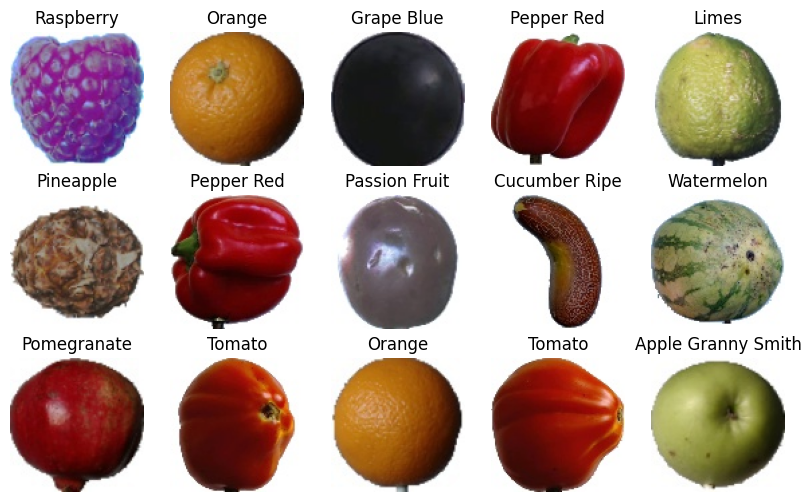

In [4]:
classes = sorted(os.listdir('train'), key=lambda x: x.lower())
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset)-1)
    img, lab = dataset[ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [5]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
print('train size:',train_size)
print('test size:',test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
# Se crea dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False)
dataloader = {
    'train': train_loader,
    'test': test_loader
}

train size: 11797
test size: 5057


In [7]:
imgs, labels = next(iter(train_loader))
print('Forma Xi:',imgs.shape)

Forma Xi: torch.Size([20, 3, 100, 100])


In [8]:
convnext = torchvision.models.convnext_small()
class Model(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()
        # descargamos convnext
        convnext = torchvision.models.convnext_small(pretrained=pretrained)
        # nos quedamos con todas las capas menos la última
        self.convnext = torch.nn.Sequential(*list(convnext.children())[:-1])
        if freeze:
            for param in self.convnext.parameters():
                param.requires_grad = False
        # añadimos una nueva capa lineal para llevar a cabo la clasificación
        self.fc = torch.nn.Linear(768, 33)

    def forward(self, x):
        x = self.convnext(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.convnext.parameters():
            param.requires_grad = True

In [9]:
def fit(model, dataloader, epochs=3, lr=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.cuda(), y.cuda()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"/nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [12]:
model = Model().cuda()
fit(model, dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
val_loss 3.55769 val_acc 0.05577: 100%|██████████| 253/253 [00:11<00:00, 21.84it/s]


Epoch 1/3 loss 9.62817 val_loss 3.55769 acc 0.03773 val_acc 0.05577


val_loss 69.26423 val_acc 0.03245: 100%|██████████| 253/253 [00:10<00:00, 23.06it/s]


Epoch 2/3 loss 193.81164 val_loss 69.26423 acc 0.03222 val_acc 0.03245


val_loss 5.82166 val_acc 0.02573: 100%|██████████| 253/253 [00:10<00:00, 24.96it/s]

Epoch 3/3 loss 19.50678 val_loss 5.82166 acc 0.03492 val_acc 0.02573


Los resultados obtenidos del entrenamiento desde cero del modelo CONVNEXT con el conjunto el dataset de frutas no es bueno, no consigue un buen porcentaje de acierto, esto talvez se deba a que el dataset es pequeño